## Statistics on disease single-cell data in cellxgene 

In [463]:
import pandas as pd
import numpy as np

R plotting setup

In [464]:
## r2py setup
# import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# anndata2ri.activate()

In [465]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [466]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

### Read data tables

In [433]:
# Filtered by organism and age (excluding fetal) 
cxg_hsapiens = pd.read_csv('/home/jovyan/mount/gdrive/sc_targetID/data/cellxgene_hsapiens_donor_metadata.csv', index_col=0)

In [434]:
## Rename diseases to include more data
disease_rename = {'cardiomyopathy':[
    'arrhythmogenic right ventricular cardiomyopathy',
     'dilated cardiomyopathy',
     'non-compaction cardiomyopathy'],
  'renal cell carcinoma':['chromophobe renal cell carcinoma', 'clear cell renal carcinoma'],
  'colorectal cancer': ['colorectal cancer', 'colorectal neoplasm'],
    'non-small cell lung carcinoma':['lung large cell carcinoma', 'non-small cell lung carcinoma']
    }

disease_rename_rev = {x:k for k,v in disease_rename.items() for x in v }

## Relevant tissue annotation for each disease
relevant_tissue_annotation = {"lung":[
    'pulmonary emphysema',
     'interstitial lung disease',
     'pulmonary fibrosis',
     'pneumonia',
     'non-small cell lung carcinoma',
     'chronic obstructive pulmonary disease',
    'squamous cell lung carcinoma',
     'lung adenocarcinoma',
    'small cell lung carcinoma',
     'cystic fibrosis'],
 'respiratory system':['respiratory system disorder'],                             
 'blood':[
     'common variable immunodeficiency',
     'influenza',
     'post-COVID-19 disorder',
     'B-cell non-Hodgkin lymphoma',
     'systemic lupus erythematosus',
     'COVID-19'
     ],
 'small intestine':[
     'Crohn ileitis',
     'Crohn disease'],
 'colon':[
     'tubulovillous adenoma',
     'colorectal cancer',
     'colon sessile serrated adenoma/polyp',   
      'hyperplastic polyp',
     'tubular adenoma',
      'adenocarcinoma'],
'stomach':[
    'gastritis',
     'stomach disorder',
     'gastric cancer',
    ],
  'esophagus':['Barrett esophagus'],
 'brain':[
     'temporal lobe epilepsy',
     'pilocytic astrocytoma',
     'Alzheimer disease',
     'dementia',
     'glioblastoma',
    ],
 'lymph node':['follicular lymphoma'],
 'kidney':[
     'renal carcinoma',
     'acute kidney failure',
     'chronic kidney disease'     
    ],
 'bone marrow':[
     'acute promyelocytic leukemia',
     'acute myeloid leukemia'     
     ],
 'heart':[
     'cardiomyopathy',
     'myocardial infarction'
 ],
 'nose':[
     'chronic rhinitis'
 ],
 'prostate gland':[
     'benign prostatic hyperplasia'
 ],
 'pancreas':[
     'type 1 diabetes mellitus'
 ],
 'breast':[
     'breast cancer'
 ],
 'female reproductive tract': [
     'malignant ovarian serous tumor'
 ]
}

relevant_tissue_annotation_rev = {x:k for k,v in relevant_tissue_annotation.items() for x in v }
keep_disease = relevant_tissue_annotation_rev.keys()

# Rename diseases 
cxg_hsapiens['disease_name_original'] = cxg_hsapiens['disease'].copy()
cxg_hsapiens['disease'] = [disease_rename_rev[x] if x in disease_rename_rev.keys() else x for x in cxg_hsapiens.disease]

# Annotate disease-relevant tissue
cxg_hsapiens = cxg_hsapiens[cxg_hsapiens['disease'].isin(list(keep_disease) + ['normal'])].copy()
cxg_hsapiens['disease_relevant_tissue'] = [relevant_tissue_annotation_rev[x] if x!= 'normal' else np.nan for x in cxg_hsapiens.disease]
cxg_hsapiens['disease_relevant_tissue'] = np.where(cxg_hsapiens['disease_relevant_tissue'].isna(), 'normal', cxg_hsapiens['disease_relevant_tissue'])

# Rename tissues
cxg_hsapiens['tissue_general_original'] = cxg_hsapiens['tissue_general'].copy()
cxg_hsapiens['tissue_general'] = ['female reproductive tract' if x in ['uterus', 'ovary', 'fallopian tube'] else x for x in cxg_hsapiens.tissue_general ]
cxg_hsapiens['tissue_general'] = ['colon' if x in ['intestine', 'large intestine', 'colon'] else x for x in cxg_hsapiens.tissue_general ]

In [435]:
# Add disease ontology
sc_data = pd.read_csv('./data/disease_ontology_tissue_donor_metadata.csv', index_col=0)
sc_data['disease_name_original'] = sc_data['disease_name'].copy()
cxg_hsapiens = pd.merge(cxg_hsapiens, sc_data[['disease_name_original', 'disease_ontology_id']].drop_duplicates(), how='left')
cxg_hsapiens = cxg_hsapiens.rename({'disease_ontology_id':'disease_ontology_id_original'},axis=1)

group_disease_ontologies = {
  'cardiomyopathy':'MONDO:0004994',
    'renal cell carcinoma':'MONDO:0005086',
    'non-small cell lung carcinoma':'MONDO:0005233',
    'colorectal cancer':'MONDO:0005575'
}

cxg_hsapiens['disease_ontology_id'] = cxg_hsapiens['disease_ontology_id_original'].copy()
cxg_hsapiens['disease_ontology_id'] = [group_disease_ontologies[x[1]['disease']] if x[1]['disease'] in group_disease_ontologies.keys() else x[1]['disease_ontology_id'] for x in cxg_hsapiens.iterrows()]
assert all(cxg_hsapiens[cxg_hsapiens['disease_ontology_id_original'] != cxg_hsapiens['disease_ontology_id']]['disease'].isin(disease_rename.keys()))

In [436]:
# Count number of donors per tissue and disease
donors_by_tissue = cxg_hsapiens[['donor_id', 'disease', 'tissue_general', 'suspension_type', 'disease_relevant_tissue']].drop_duplicates()
donors_by_tissue = donors_by_tissue.groupby(['disease', 'tissue_general', 'disease_relevant_tissue']).size().reset_index()
donors_by_tissue.columns = ['disease', 'tissue_general', 'disease_relevant_tissue','n_donors']

In [461]:
keep_columns = ['assay', 'tissue', 'tissue_general', 'suspension_type', 'disease',
       'dataset_id', 'donor_id',
       'development_stage_ontology_term_id', 'sample_id',
       'disease_name_original', 'disease_relevant_tissue',
       'tissue_general_original', 'disease_ontology_id_original',
       'disease_ontology_id']

In [ ]:
# Save output 
cxg_hsapiens[keep_columns].to_csv('/home/jovyan/mount/gdrive/sc_targetID/data/cellxgene_hsapiens_donor_metadata.disease_relevant_annotation.csv')
donors_by_tissue.to_csv('/home/jovyan/mount/gdrive/sc_targetID/data/cellxgene_hsapiens_donor_by_tissue.csv.disease_relevant_annotation.csv')

### For which diseases do we have sc data?

In [437]:
df = donors_by_tissue.groupby(['disease']).sum('n_donors').reset_index()

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


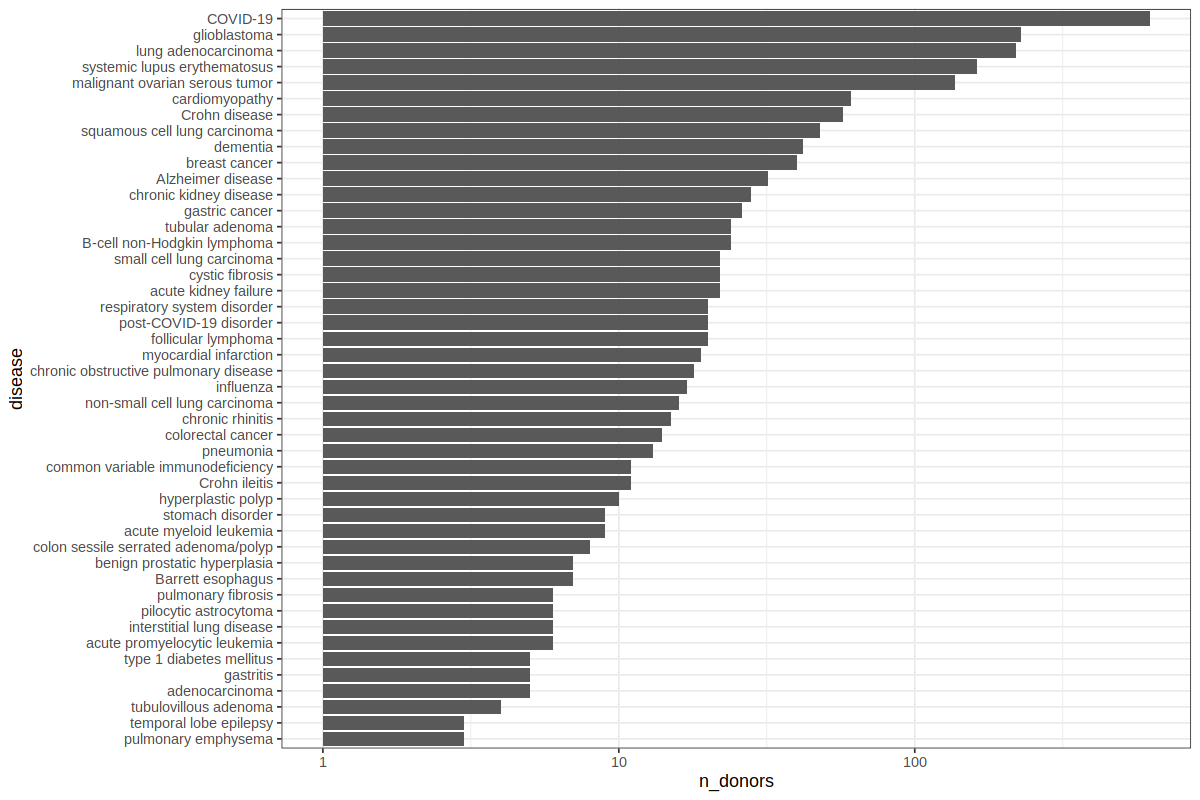

In [438]:
%%R -i df  -w 1200 -h 800
pl_df <- df %>%
    filter(disease != 'normal') %>%
    filter(n_donors >= 3) %>%
    arrange(n_donors) %>%
    mutate(disease = factor(disease, levels=unique(disease))) 

keep_diseases <- levels(pl_df$disease) %>% as.character()
    
pl_df %>%
    ggplot(aes(disease, n_donors)) +
    geom_col() +
    coord_flip() +
    scale_y_log10() +
    theme_bw(base_size=18)

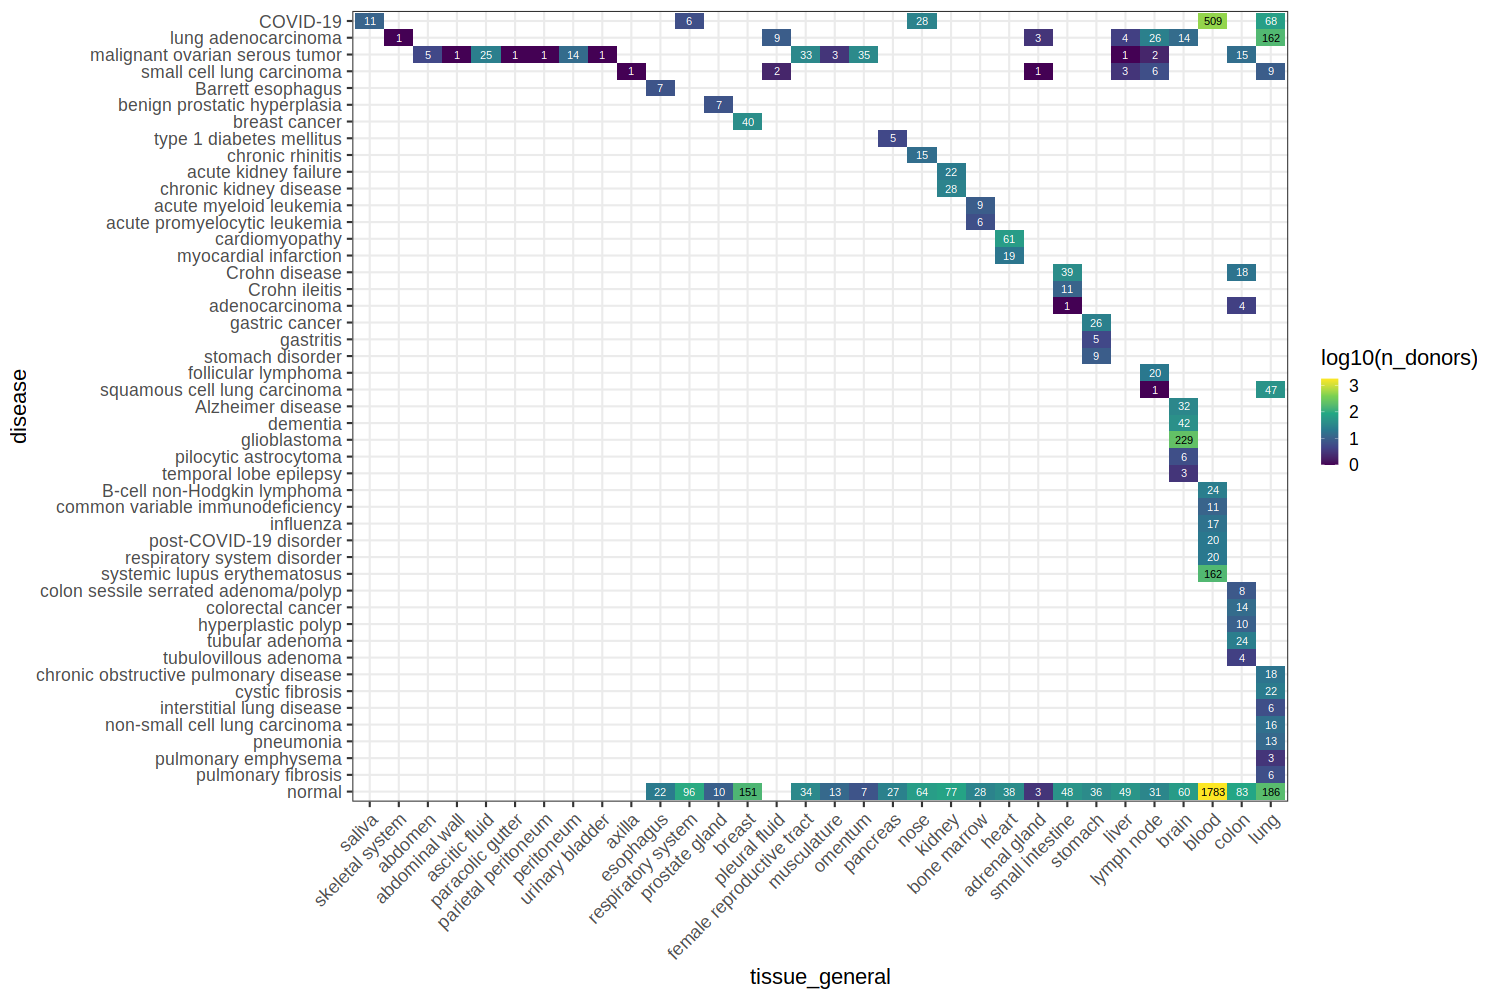

In [439]:
%%R -w 1500 -h 1000 -o disease_order 
pl_df <- donors_by_tissue %>%
    filter(disease %in% c(as.character(keep_diseases), 'normal')) %>%
    group_by(tissue_general) %>%
    mutate(n_diseases = n()) %>%
    filter(!all(disease == 'normal')) %>%
    ungroup() %>%
    arrange(n_diseases) %>%
    mutate(tissue_general = factor(tissue_general, levels=unique(tissue_general))) %>%
    arrange(tissue_general) %>%
    mutate(disease = factor(disease, levels=c('normal', setdiff(rev(unique(disease)), c('normal'))))) %>%
    mutate(text_color=ifelse(n_donors > 100, 'black', 'white')) 

disease_order <- levels(pl_df$disease) %>% as.character()
    
pl2 <- pl_df %>%
    ggplot(aes(tissue_general, disease)) +
    geom_tile(aes(fill=log10(n_donors))) +
    geom_text(aes(label=n_donors, color=text_color)) +
    scale_fill_viridis_c() +
    scale_color_manual(values=c(white='white', black='black')) +
    guides(color='none') +
    theme_bw(base_size=22) +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1)) 
    
pl2

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


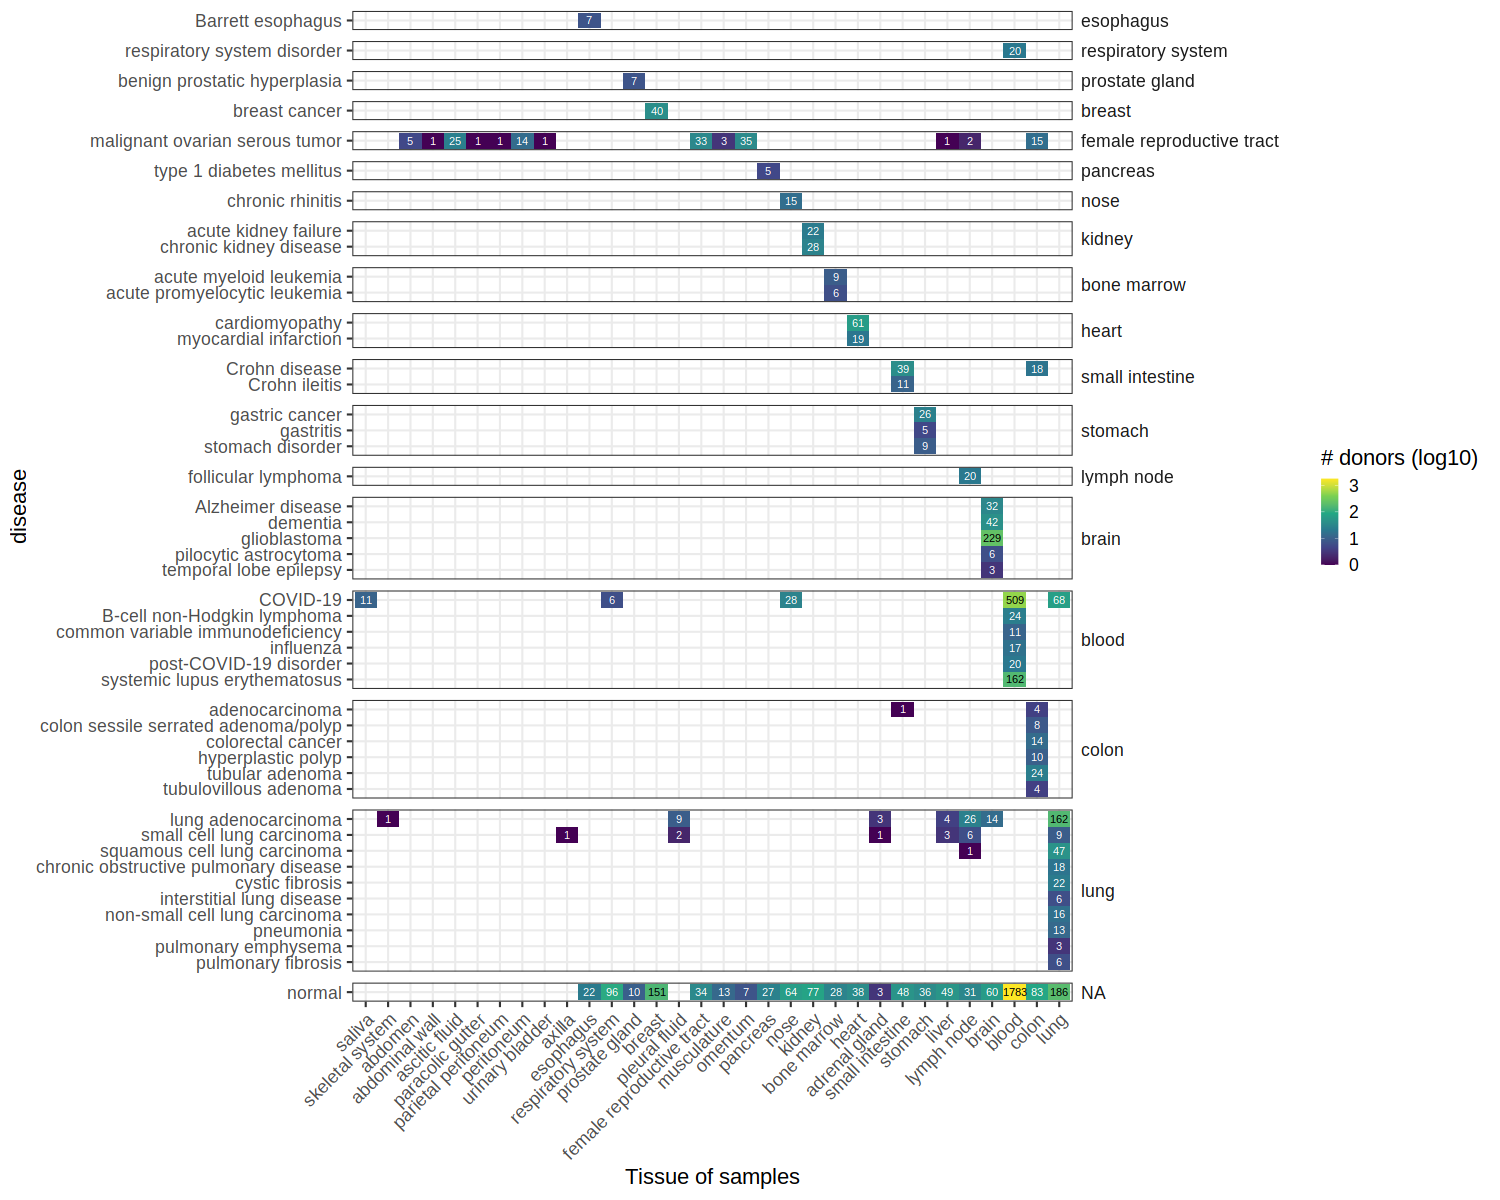

In [440]:
%%R -w 1500 -h 1200 -o disease_order -i donors_by_tissue
pl_df <- donors_by_tissue %>%
    filter(disease %in% c(as.character(keep_diseases), 'normal')) %>%
    group_by(tissue_general) %>%
    mutate(n_diseases = n()) %>%
    filter(!all(disease == 'normal')) %>%
    ungroup() %>%
    arrange(n_diseases) %>%
    mutate(tissue_general = factor(tissue_general, levels=unique(tissue_general))) %>%
    mutate(disease_relevant_tissue = factor(disease_relevant_tissue, levels=levels(tissue_general))) %>%
    arrange(tissue_general) %>%
    mutate(disease = factor(disease, levels=c('normal', setdiff(rev(unique(disease)), c('normal'))))) %>%
    mutate(text_color=ifelse(n_donors > 100, 'black', 'white')) 

disease_order <- levels(pl_df$disease) %>% as.character()
    
pl2 <- pl_df %>%
    ggplot(aes(tissue_general, disease)) +
    geom_tile(aes(fill=log10(n_donors))) +
    geom_text(aes(label=n_donors, color=text_color)) +
    scale_fill_viridis_c(name='# donors (log10)') +
    scale_color_manual(values=c(white='white', black='black')) +
    guides(color='none') +
    xlab('Tissue of samples') +
    theme_bw(base_size=22) +
        facet_grid(disease_relevant_tissue~., space='free', scales='free') +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1), strip.text.y = element_text(angle=0, hjust=0), strip.background=element_blank()) 

    pl2

### For which disease-relevant tissues do we have single-cell data?

In [441]:
# donors_by_tissue = donors_by_tissue[donors_by_tissue.disease=='normal']
donors_by_tissue['disease_relevant'] = donors_by_tissue['tissue_general'].isin(relevant_tissue_annotation.keys())

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


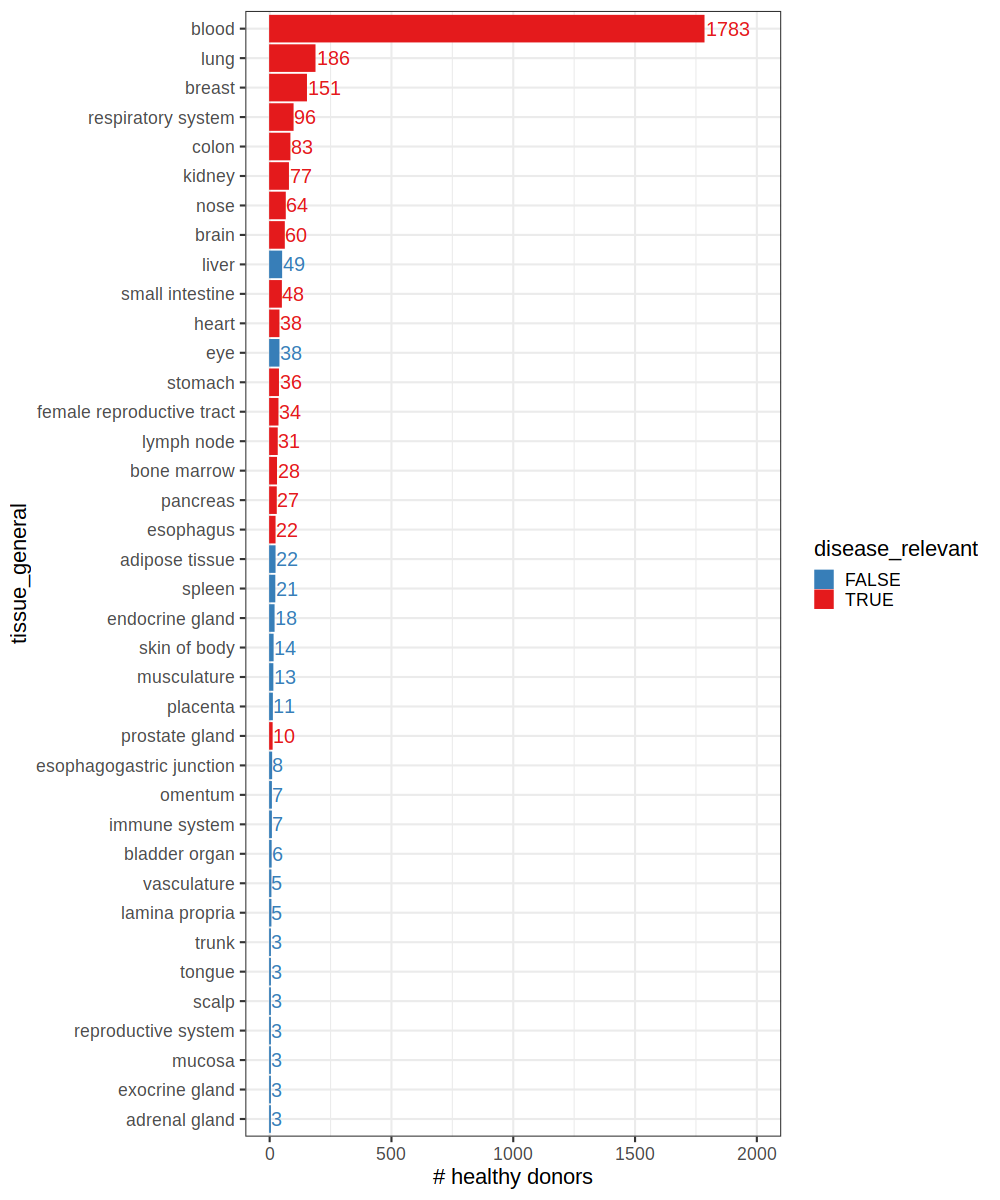

In [457]:
%%R -i donors_by_tissue -w 1000 -h 1200
donors_by_tissue %>% 
filter(disease == 'normal') %>%
filter(n_donors >= 3) %>%
arrange(n_donors) %>%
mutate(tissue_general = factor(tissue_general, unique(tissue_general))) %>%
ggplot(aes(tissue_general, n_donors, fill=disease_relevant, color=disease_relevant)) +
geom_col() +
geom_text(aes(label=n_donors), size=7, hjust=-.05) +
scale_fill_brewer(palette='Set1', direction=-1) +
scale_color_brewer(palette='Set1', direction=-1) +
ylim(0,2000) +
ylab('# healthy donors') +
# facet_grid(disease_relevant~., space='free', scale='free') +
# scale_y_log10() +
coord_flip() +
theme_bw(base_size=22)

### What is the overlap between drug indications in OT and available sc data?

In [589]:
# Read cxg metadata
cxg_hsapiens = pd.read_csv('/home/jovyan/mount/gdrive/sc_targetID/data/cellxgene_hsapiens_donor_metadata.disease_relevant_annotation.csv', index_col=0)
donors_by_tissue = pd.read_csv('/home/jovyan/mount/gdrive/sc_targetID/data/cellxgene_hsapiens_donor_by_tissue.disease_relevant_annotation.csv', index_col=0)

# Read OT targets table
ot_table = pd.read_csv('./data/TargetDiseasePairs_hasKnownDrug_OpenTargets_cellxgeneEFO_06092023.csv', index_col=0)
ot_disease_info = pd.read_csv('./data/DiseasesInformation_OpenTargets_06092023.csv', index_col=0)

In [590]:
all_diseases = ot_disease_info['name'].unique()
# ot_disease_info[ot_disease_info['name'] == 'inflammatory bowel disease']

,id,name,therapeuticAreas,therapeuticAreas_text
6627,EFO_0003767,inflammatory bowel disease,"['OTAR_0000018', 'EFO_0000540', 'EFO_0010282']","['genetic, familial or congenital disease', 'i..."


In [499]:
import ast
all_disease_ids = sum([ast.literal_eval(x) for x in ot_disease_info.therapeuticAreas.tolist()], [])

[x for x in all_disease_ids if x in cxg_hsapiens.disease_ontology_id]

[]

In [486]:
disease_ids = ot_table.diseaseId.unique()
cxg_hsapiens[cxg_hsapiens.disease_ontology_id.str.replace(':',"_").isin(disease_ids)]['disease'].unique()

array(['breast cancer', 'COVID-19', 'cystic fibrosis',
       'pilocytic astrocytoma', 'gastric cancer',
       'common variable immunodeficiency',
       'malignant ovarian serous tumor', 'follicular lymphoma',
       'acute kidney failure', 'systemic lupus erythematosus',
       'Alzheimer disease', 'type 1 diabetes mellitus'], dtype=object)

In [591]:
import obonet
import networkx
# mondo_id = 'MONDO:0012419'
flu_efo = 'EFO:0007328'

# obo_file = "./data/efo.obo"  # downloaded from http://obofoundry.org/ontology/cl.html

# Load the ontology from the OBO file
EFO_GRAPH = obonet.read_obo('https://www.ebi.ac.uk/efo/efo.obo')


In [644]:
def get_MONDO_from_EFO(efo_id):
    if '_' in efo_id:
        efo_id = efo_id.replace('_', ":")
    try:
        synonyms = EFO_GRAPH.nodes[efo_id]['xref']
    except KeyError:
#         print('No matching MONDO id')
        return efo_id
    mondo_ids = [x for x in synonyms if x.startswith('MONDO:')]
    if len(mondo_ids) > 1:
        print("multiple MONDO matches - returning first instance")
    elif len(mondo_ids) < 1:
#         print('No matching MONDO id')
        return efo_id
    return(mondo_ids[0])

In [656]:
ot_disease_info = pd.read_csv('./data/DiseasesInformation_OpenTargets_06092023.csv', index_col=0)
ot_disease_info['cxg_matched_id'] = [get_MONDO_from_EFO(x['id']) if x['id'].startswith('EFO') else x['id'] for i, x in ot_disease_info.iterrows()]
ot_disease_info['cxg_matched_id'] = [x.replace(':', "_") for x in ot_disease_info['cxg_matched_id']]

multiple MONDO matches - returning first instance
multiple MONDO matches - returning first instance
multiple MONDO matches - returning first instance


In [668]:
ot_disease_info.to_csv('./data/DiseasesInformation_OpenTargets_06142023.csv')

In [665]:
cxg_hsapiens = pd.read_csv('/home/jovyan/mount/gdrive/sc_targetID/data/cellxgene_hsapiens_donor_metadata.disease_relevant_annotation.csv', index_col=0)
cxg_disease_ids = cxg_hsapiens[['disease','disease_ontology_id']].drop_duplicates()
cxg_disease_ids['disease_ontology_id'] = [x.replace(":", "_") for x in cxg_disease_ids['disease_ontology_id']]
cxg_disease_ids.disease_ontology_id.isin( ot_disease_info['cxg_matched_id'] ).value_counts()

True     46
False     1
Name: disease_ontology_id, dtype: int64

### For how many indications do we have data from the healthy "affected tissue" but not the disease data?

---

In [291]:
cxg_hsapiens[cxg_hsapiens['tissue_general'] == 'intestine']

,assay,tissue,tissue_general,suspension_type,disease,dataset_id,is_primary_data,donor_id,development_stage_ontology_term_id,sample_id,is_fetal
12203957,10x 3' v3,intestine,intestine,cell,malignant ovarian serous tumor,b252b015-b488-4d5c-b16e-968c13e48a2c,True,SPECTRUM-OV-107,HsapDv:0000154,10x 3' v3intestineSPECTRUM-OV-107,False
12294089,10x 3' v3,intestine,intestine,cell,malignant ovarian serous tumor,b252b015-b488-4d5c-b16e-968c13e48a2c,True,SPECTRUM-OV-090,HsapDv:0000164,10x 3' v3intestineSPECTRUM-OV-090,False
12343085,10x 3' v3,intestine,intestine,cell,malignant ovarian serous tumor,b252b015-b488-4d5c-b16e-968c13e48a2c,True,SPECTRUM-OV-082,HsapDv:0000163,10x 3' v3intestineSPECTRUM-OV-082,False
12577135,10x 3' v3,intestine,intestine,cell,malignant ovarian serous tumor,b252b015-b488-4d5c-b16e-968c13e48a2c,True,SPECTRUM-OV-014,HsapDv:0000095,10x 3' v3intestineSPECTRUM-OV-014,False
12588409,10x 3' v3,intestine,intestine,cell,malignant ovarian serous tumor,b252b015-b488-4d5c-b16e-968c13e48a2c,True,SPECTRUM-OV-008,HsapDv:0000158,10x 3' v3intestineSPECTRUM-OV-008,False
12742812,10x 3' v3,intestine,intestine,cell,malignant ovarian serous tumor,b252b015-b488-4d5c-b16e-968c13e48a2c,True,SPECTRUM-OV-051,HsapDv:0000162,10x 3' v3intestineSPECTRUM-OV-051,False
12853155,10x 3' v3,intestine,intestine,cell,malignant ovarian serous tumor,b252b015-b488-4d5c-b16e-968c13e48a2c,True,SPECTRUM-OV-026,HsapDv:0000151,10x 3' v3intestineSPECTRUM-OV-026,False
12882086,10x 3' v3,intestine,intestine,cell,malignant ovarian serous tumor,b252b015-b488-4d5c-b16e-968c13e48a2c,True,SPECTRUM-OV-025,HsapDv:0000169,10x 3' v3intestineSPECTRUM-OV-025,False
12921973,10x 3' v3,intestine,intestine,cell,malignant ovarian serous tumor,b252b015-b488-4d5c-b16e-968c13e48a2c,True,SPECTRUM-OV-022,HsapDv:0000152,10x 3' v3intestineSPECTRUM-OV-022,False
12976336,10x 3' v3,intestine,intestine,cell,malignant ovarian serous tumor,b252b015-b488-4d5c-b16e-968c13e48a2c,True,SPECTRUM-OV-009,HsapDv:0000144,10x 3' v3intestineSPECTRUM-OV-009,False
